The paper shows that neural networks can keep generalizing when large numbers of (non-adversarially) incorrectly labeled examples are added to datasets (MNIST, CIFAR, and ImageNet). It also appears that larger networks are more robust and that higher noise levels lead to lower optimal (fixed) learning rates.

We'll focus on the uniform label noise experiment and attempt to reproduce Figure 1:

![Figure 1. As we increase the amount of noise in the dataset the performance drops. However, note that even when there are 100 noisy labels *per* clean label performance is still acceptable. For example, the Convnet still achieves 91% accuracy.](images/fig1.png){width=300 fig-align="center"}

Note: As far as I can tell the paper has no accompanying code so I'll be filling in the details to the best of my abilities.

In [1]:
#| code-summary: Imports and model evaluation function
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, itertools, time

os.makedirs('logs', exist_ok = True)
os.makedirs('models', exist_ok = True)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device(
    'cuda' if torch.cuda.is_available() else
    ('mps' if torch.backends.mps.is_available() else
    'cpu')
)
device = 'cpu' # faster for the small models we are using

def eval_model(model, test, criterion = nn.CrossEntropyLoss()):
    model.eval()
    correct, loss = 0, 0.0
    with torch.no_grad():
        for images, labels in test:
            images, labels = images.to(device), labels.to(device)
            _, pred = torch.max(model(images), 1)
            correct += (pred == labels).float().sum().item()
            loss += criterion(model(images), labels).item()
    return loss / len(test.dataset), correct / len(test.dataset)

To generate the uniform label noise the paper augments the original dataset with an additional $\alpha$ $(X_i, Y')$ pairs, where $Y'$ is a class sampled uniformly at random with replacement.

To minimize disk use I opted for a custom dataset that wraps the original. Pytorch only requires we override `__len__` and `__getitem__`. The length is simply the original size plus the amount of noisy labels. When queried for data we'll generate the noisy labels for the original pairs immediately after it. For example when $\alpha = 2$:

$$
(X_1, Y_1), (X_1, Y'), (X_1, Y'), (X_2, Y_2), ...
$$

Note that to guarantee that noisy labels are consistent between epocs, i.e. data[1] returns the same class when called again, we can't sample the labels at query time. To avoid storing all the randomly sampled labels ($60, 000 \times 100$ in the worst case), we simply return a shifted index's label. We can do this with MNIST because its reasonably class-balanced and shuffled.

In [3]:
#| code-fold: false
class NoisyLabelDataset(Dataset):
    """Adds alpha noisy labels per original example"""
    
    def __init__(self, dataset, alpha):
        self.dataset = dataset
        self.alpha = alpha
        self.shift = np.random.randint(0, len(dataset))

    def __len__(self):
        n = len(self.dataset)
        return n + (self.alpha * n)
    
    def __getitem__(self, idx):
        x, y = self.dataset[idx // (self.alpha + 1)]
        if idx % (self.alpha + 1) != 0:
            y = self.dataset[(idx + self.shift) % len(self.dataset)][1]
        return x, y

Although the paper appears to only include a test set, we also include a validation set to perform early stopping with.

In [4]:
#| code-summary: Datasets and loaders
batch_size = 128

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST('data', download = True, train = True,   transform = transform)
test_dataset =  datasets.MNIST('data', download = True, train = False,  transform = transform)

noisy_train_dataset = NoisyLabelDataset(train_dataset, alpha = 5)
val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, (0.2, 0.8), generator = torch.Generator().manual_seed(seed))

train_loader = DataLoader(noisy_train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

Our training loop is pretty standard. We use the `Adadelta` optimizer as per the paper. Although the paper does not mention it, we assume they used early stopping: stop training when the validation accuracy does not increase after `patience` epochs and return the model with the highest validation accuracy.

In [5]:
#| code-summary: Training function
def train(model, train_loader, val_loader, lr = 0.01, patience = 3, max_epochs = 100, verbose = False):
    
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adadelta(model.parameters(), lr = lr)

    log = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    best_val_acc = float('inf')
    best_model = None

    for epoch in range(max_epochs):

        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(images), labels)
            loss.backward()
            optimizer.step()

        val_loss, val_acc = eval_model(model, val_loader)
        log['train_loss'].append(loss.item())
        log['val_loss'].append(val_loss)
        log['val_acc'].append(val_acc)

        if verbose: print(', '.join([f'Epoch {epoch + 1}'] + [f'{k}: {v[-1]:.4f}' for k, v in log.items()]))

        if val_acc < best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict()

        # Early stopping: stop if val acc has not increased in the last `patience` epochs
        if epoch > patience and val_acc <= max(log['val_acc'][-patience-1:-1]): break 
    
    if best_model: model.load_state_dict(best_model)
    return model, log

We train with learning rates $\{0.01, 0.05, 0.1, 0.5\}$ as per the paper and $\alpha \in \{0, 25, 50\}$ to save some compute (we should get the idea). Below we define our perceptron, MLPs with 1, 2, and 4 layers and a 4-layer Convnet. Again, since the paper does not specify hidden dims, activations, or the convnet architecture, we set it ourselves.

In [6]:
#| code-summary: Hyperparam and model definitions
learning_rates = [0.01, 0.05, 0.1, 0.5]
alphas = range(0, 75, 25)

lin_relu = lambda n_in, n_out: nn.Sequential(nn.Linear(n_in, n_out), nn.ReLU())
models = {
    'perceptron':nn.Sequential(nn.Flatten(), nn.Linear(28 * 28, 10)),
    'MLP1':nn.Sequential(nn.Flatten(), lin_relu(28 * 28, 256), nn.Linear(256, 10)),
    'MLP2':nn.Sequential(nn.Flatten(), lin_relu(28 * 28, 256), lin_relu(256, 128), nn.Linear(128, 10)),
    'MLP4':nn.Sequential(nn.Flatten(), lin_relu(28 * 28, 256), lin_relu(256, 128), lin_relu(128, 64), nn.Linear(64, 10)),
    'Conv4':nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        
        nn.Flatten(),
        nn.Linear(256 * 1 * 1, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    )
}

In [7]:
#| output: false
#| code-summary: Train and save models
for alpha, (name, model), lr in itertools.product(alphas, models.items(), learning_rates):

    noisy_train_dataset = NoisyLabelDataset(train_dataset, alpha = alpha)
    train_loader = DataLoader(noisy_train_dataset, batch_size = batch_size, shuffle = True)
    
    start = time.time()
    model, log = train(model, train_loader, val_loader, lr = lr, verbose = True)
    test_loss, test_acc = eval_model(model, test_loader)
    log['test_loss'] = test_loss
    log['test_acc'] = test_acc

    print(f'{name} - alpha: {alpha}, lr: {lr}, test acc: {test_acc:.4f}, took: {time.time() - start:.2f}s')
    torch.save(log, f'logs/{name}_{alpha}_{lr}.pt')
    torch.save(model, f'models/{name}_{alpha}_{lr}.pt')

Epoch 1, train_loss: 1.2487, val_loss: 0.0103, val_acc: 0.7740
Epoch 2, train_loss: 0.8007, val_loss: 0.0069, val_acc: 0.8380
Epoch 3, train_loss: 0.7382, val_loss: 0.0053, val_acc: 0.8675
Epoch 4, train_loss: 0.6066, val_loss: 0.0044, val_acc: 0.8790
Epoch 5, train_loss: 0.7068, val_loss: 0.0039, val_acc: 0.8860
Epoch 6, train_loss: 0.3720, val_loss: 0.0036, val_acc: 0.8940
Epoch 7, train_loss: 0.5438, val_loss: 0.0033, val_acc: 0.9000
Epoch 8, train_loss: 0.3984, val_loss: 0.0032, val_acc: 0.9030
Epoch 9, train_loss: 0.5114, val_loss: 0.0030, val_acc: 0.9050
Epoch 10, train_loss: 0.3531, val_loss: 0.0029, val_acc: 0.9030
perceptron - alpha: 0, lr: 0.01, test acc: 0.8902, took: 31.05s
Epoch 1, train_loss: 0.4750, val_loss: 0.0026, val_acc: 0.9150
Epoch 2, train_loss: 0.3106, val_loss: 0.0024, val_acc: 0.9165
Epoch 3, train_loss: 0.2863, val_loss: 0.0023, val_acc: 0.9195
Epoch 4, train_loss: 0.2613, val_loss: 0.0022, val_acc: 0.9260
Epoch 5, train_loss: 0.2982, val_loss: 0.0022, val_ac

KeyboardInterrupt: 

Finally, we plot the accuracies on both the validation and test sets:

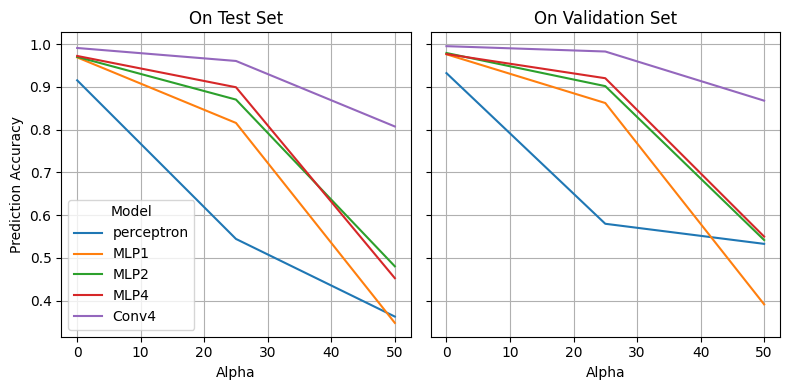

In [44]:
#| code-summary: Plot results

# Load results into dataframe
df = []
for fname in os.listdir('logs'):
    name, alpha, lr = fname.split('_')
    lr = float(lr.replace('.pt', ''))
    alpha = int(alpha)
    
    log = torch.load('logs/' + fname)
    tmp = {}
    tmp['Model'] = name
    tmp['Alpha'] = alpha
    tmp['lr'] = lr
    tmp['Prediction Accuracy'] = log['test_acc']
    tmp['Validation Accuracy'] = max(log['val_acc'])
    df.append(tmp)
df = pd.DataFrame(df)

hue_order = ['perceptron', 'MLP1', 'MLP2', 'MLP4', 'Conv4']

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4), sharey = True, sharex = True)

sns.lineplot(
    df.groupby(['Model', 'Alpha']).max(), x = 'Alpha', y = 'Prediction Accuracy',
    hue = 'Model', hue_order = hue_order, ax = ax1
)
ax1.set_title('On Test Set')
ax1.grid()

sns.lineplot(
    df.groupby(['Model', 'Alpha']).max(), x = 'Alpha', y = 'Validation Accuracy',
    hue = 'Model', hue_order = hue_order, ax = ax2, legend = False
)
ax2.set_title('On Validation Set')
ax2.grid()
plt.tight_layout()


We observe that the general trends seem to hold. As we add noise the performance drops and larger models tend to be more robust.

However, our models overall tend to perform worse than the paper's. At $\alpha = 50$ most of our models have accuracies below $60\%$, whereas the paper's are around the high $80\%$'s. In addition, our Conv4 model is already below 90% when the paper archives 91% at $\alpha = 100$.

This might be due to differences in training (use and implementation of early stopping), architecture implementation, random seeds (we did not try multiple / averaging because of compute), etc.

We also observe the trend the paper points out (in Section 5) that higher noise levels lead to smaller effective batch sizes and thus lower optimal learning rates:

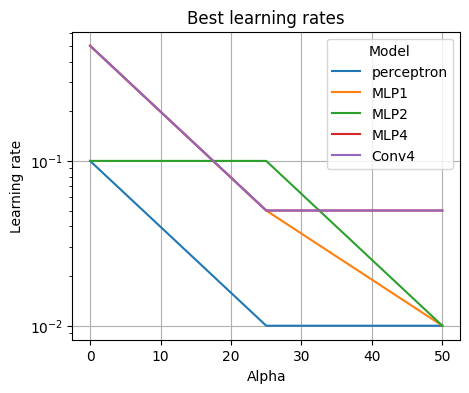

In [71]:
#| code-summary: Compute best learning rates
#| echo: false
best_lrs = []
for alpha in df['Alpha'].unique():
    for model in df['Model'].unique():
        tmp = df[(df['Alpha'] == alpha) & (df['Model'] == model)]
        ix = tmp['Prediction Accuracy'].argmax()
        best_lrs.append({'best lr': tmp['lr'].iloc[ix], 'Alpha': alpha, 'Model': model})

best_lrs = pd.DataFrame(best_lrs)

plt.figure(figsize = (5, 4))
sns.lineplot(
    best_lrs, x = 'Alpha', y = 'best lr', hue = 'Model', hue_order = hue_order
)
plt.yscale('log')
plt.grid()
plt.ylabel('Learning rate')
plt.title('Best learning rates')
plt.show()

A few closing thoughts: Although our results did not completely align with the paper, we still find the robustness to noise impressive. 

The paper performs and studies the effect much further under non-uniform noise, with different datasets, batch sizes, etc. It is worth a [read](https://arxiv.org/pdf/1705.10694). 

I might revisit this notebook to perform further experiments and try to answer some lingering questions:

- Does within epoch sample ordering matter? Intuitively, if we place all clean labels before the noisy ones, one expects worse performance (catastrophic forgetting?)
- What effect does early stopping have? We used a clean validation set to determine when to stop -- which is not realistic. What happens if we use the loss or no early stopping?